# Implementation of a Neural Network Classification Model
**Joey Shi**

In this notebook, we will describe the implementation details and theory behind neural network classification.
The topics covered will include the softmax loss function, computing gradients for multi-variable vector functions, and the gradient descent algorithm.

## Notation
1. $X$ is a $n \times d$ feature matrix of real numbers, such that each row $x_i\in\mathbb{R}^d$ is an example.
2. $y$ is an $n$-dimensional label vector, such that each $y_i\in\{1,2,\dots , k_L\}$ is a class label.
3. $h(z)$ is a non-linear function. We will refer this as an activation function.
4. $W^{(l)}$ is a $k_{l} \times k_{l-1}$ weight matrix.
5. $b^{(l)}$ is a $k_{l}$-dimensional bias vector.
6. $p(y_i \mid D, x_i)$ is the probability of predicting $y_i$ from $x_i$ and parameters $D$
7. $\delta_{a, b} = 1$ if $a = b$, $\delta_{a, b} = 0$ otherwise [Kronecker delta function].

n = 50000, d = 784
digit = 5


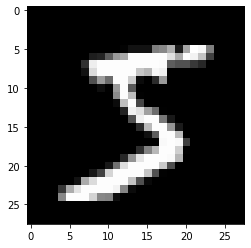

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle

# Load mnist data set of 26x26 hand-drawn digits
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

X, y = train_set
X_test, y_test = test_set
examples, pixels = X.shape
print(f"n = {examples}, d = {pixels}")

# Preview data set
example = 0
print(f"digit = {y[example]}")
image = np.reshape(X[example], (28, 28))
plt.imshow(image, cmap='gray')
plt.show()

# Maximum Likelihood Estimate

We begin by defining our model's probability mass distribution:
\begin{align*}
    p(y_i \mid D, x_i) &= \frac{\exp\left(z_{i,y_i}^{(L)}\right)}{\sum_{c=1}^k \exp\left(z_{i,c}^{(L)}\right)} \tag{z_i^{(L)} \text{ is defined in section 4}}
\end{align*}
We choose this probability mass function for our classification problem because of its behaviour: $p(y_i \mid D, x_i)$ is larger if $z_{i,y_i}^{(L)} = \max_{c} z_{i,c}^{(L)}$ and small otherwise. For our model, we want to maximize this probability across all training example, so we maximize $p(y \mid D, X)$. Assuming that each example is i.i.d., we can equivalently minimize $-\log(p(y \mid D, X))$ to avoid underflow during computation.
\begin{align}
    -\log(p(y \mid D, X))
    &= -\log\left(\prod_{i=1}^n p(y_i = c \mid D, x_i)\right) \\
    &= \sum_{i=1}^n -\log(p(y_i \mid D, x_i)) \\
    &= \sum_{i=1}^n -z_{i, y_i}^{(L)} + \log\left(\sum_{c=1}^{k} \exp\left(z_{i, c}^{(L)}\right)\right) \tag{\text{Softmax Loss Function}}
\end{align}

In [83]:
def softmax_loss(Z: np.ndarray, y: np.ndarray):
    """Returns the softmax loss of Z"""
    z = np.zeros(examples)
    for i, d in enumerate(y):
        z[i] = Z[i][d]

    log_exp_sum = np.log(np.sum(np.exp(Z), axis=1))
    return np.sum(-z + log_exp_sum)

# Objective Function

Consider the following feed-forward neural network.
For an input layer defined by $x_i$, our hidden layers are defined by the activation vectors $a_i^{(l)}$ and our output layer is defined by $z_i^{(L)}$.

Note: We add hidden layers so our model can learn about latent factors in the data during training.
\begin{align*}
    a_i^{(0)} &= x_i & z_i^{(1)} &= W^{(1)}a_i^{(0)} + b^{(1)} \\
    a_i^{(1)} &= h\left(z^{(1)}\right) & z_i^{(2)} &= W^{(2)}a_i^{(1)} + b^{(2)} \\
    \vdots & & \vdots \\
    a_i^{(L-1)} &= h\left(z^{(L-1)}\right) & z_i^{(L)} &= W^{(L)}a_i^{(L-1)} + b^{(L)}
\end{align*}
After some weight initialization, given an example $x_i$, our model would predict $\displaystyle\hat{y}_i = \underset{c}{\text{argmax}} z_{i,c}^{(L)}$. Using softmax loss, our objective function becomes
\begin{align*}
    f(W, b) &= \sum_{i=1}^{n} \left[-z_{i, y_i}^{(L)} + \log\left(\sum_{c=1}^{k} \exp\left(z_{i, c}^{(L)}\right)\right)\right]
\end{align*}

# Gradients of the Objective Function
Let $A^{(l)}$ be a matrix such that each row is an activation vector $a_i^{(l)}$ and let $Z^{(l)}$ be defined similarly.
Define a new matrix R by the recursion relation $R^{(l-1)} = R^{(l)}W^{(l)} \circ h\,'\left(Z^{(l-1)}\right)$ with a base case of $R^{(L)}$, where $r_{i, c}^{(L)} = p(y_i = c \mid D, x_i) - \delta_{y_i, c}$.
Then the derivatives of the weights and biases of our network are given by
$$
\frac{\partial f}{\partial W^{(l)}} = \left(R^{(l)}\right)^TA^{(l-1)} \hspace{1cm} \frac{\partial f}{\partial b^{(l)}} = \sum_{i=1}^{n} r_i^{(l)}
$$

**Gradient of $W^{(L)}$ and $b^{(L)}$**
\begin{align*}
    \frac{\partial f}{\partial w_{c,j}^{(L)}} &= \sum_{i=1}^{n} \left[-a_{i,j}^{(L-1)}\delta_{y_i, c} + \frac{1}{\sum_{c_0=1}^{k_l} \exp\left(z_{i,c_0}^{(L)}\right)}  \cdot \exp\left(z_{i,c}^{(L)}\right) \cdot a_{i,j}^{(L-1)}\right] &[\text{Chain Rule}] \\
    &= \sum_{i=1}^{n} [p(y_i = c \mid D, x_i) - \delta_{y_i,c}]a_{i,j}^{(L-1)} \\
    &= \sum_{i=1}^{n} r_{i,c}^{(L)}a_{i,j}^{(L-1)} \\
    \frac{\partial f}{\partial W^{(L)}} &= \left(R^{(L)}\right)^TA^{(L-1)} \\
    \frac{\partial f}{\partial b_{c}^{(L)}} &= \sum_{i=1}^{n} r_{i, c}^{(L)} \cdot 1 &[\text{Similar work as above}] \\
    \frac{\partial f}{\partial b^{(L)}} &= \sum_{i=1}^{n} r_i^{(L)}
\end{align*}

**Gradient of $W^{(L-1)}$ and $b^{(L-1)}$**
\begin{align*}
    \frac{\partial f}{\partial w_{j, k}^{(L-1)}} &= \sum_{i=1}^{n} \sum_{c=1}^{k_L} \left[p(y_i = c \mid D, x_i) - \delta_{y_i, c}\right] \cdot w_{c,j}^{(L)}  h\,'\left(z_{j, k}^{(L-1)}\right) \cdot a_{j, k}^{(L-2)} &[\text{Chain Rule}]\\
    &= \sum_{i=1}^{n} \sum_{c=1}^{k_L} r_{i,c}^{(L)} \cdot w_{c,k}^{(L)}h\,'\left(z_{i, k}^{(L-1)}\right) \cdot a_{i, k}^{(L-2)} \\
    &= \sum_{i=1}^{n} \left[\left(W^{(L)}\right)^T r_i^{(L)} \circ h\,'\left(z_{i}^{(L-1)}\right)\right] \cdot a_i^{(L-2)} \\
    &= \sum_{i=1}^{n} r_{i}^{(L-1)} \cdot a_i^{(L-2)} \\
    &= \left(R^{(L-1)}\right)^T A^{(L-2)} \\
    \frac{\partial f}{\partial b_{k}^{(L-1)}} &= \sum_{i=1}^{n} r_{i, k}^{(L-1)} \cdot 1 &[\text{Similar work as above}] \\
    \frac{\partial f}{\partial b^{(L-1)}} &= \sum_{i=1}^{n} r_i^{(L-1)}
\end{align*}

**The following derivations are trivial and left as an easy exercise for the reader**

In [84]:
# Hyper parameters
hidden_layer_sizes = [100]
alpha = 0.001
batches = 10
epochs = 5

# Random initialization
weights = []
biases = []
layer_sizes = [X.shape[1]] + hidden_layer_sizes + [np.unique(y).size]
for i in range(1, len(layer_sizes)):
    weights.append(0.01 * np.random.randn(layer_sizes[i], layer_sizes[i - 1]))
    biases.append(0.01 * np.random.rand(layer_sizes[i]))

In [85]:
def fun_obj(weights, biases):
    activations = [X]
    activation_derivs = []
    A = X
    Z = None
    for i, (W, b) in enumerate(zip(weights, biases)):
        Z = A @ W.T + b
        if i < len(weights) - 1:
            A = 1 / (1 + np.exp(-Z))
            activations.append(A)
            activation_derivs.append(A * (1 - A))

    f = softmax_loss(Z, y)
    G = np.exp(Z) / np.sum(np.exp(Z), axis=1)[:, None]
    for i, d in enumerate(y):
        G[i][d] -= 1

    grad_W = [None] * (len(layer_sizes) - 1)
    grad_b = [None] * (len(layer_sizes) - 1)

    grad_W[-1] = G.T @ activations[-1]
    grad_b[-1] = np.sum(G, axis=0)

    for i in range(len(layer_sizes) - 3, -1, -1):
        G = G @ weights[i + 1] * activation_derivs[i]
        grad_W[i] = G.T @ activations[i]
        grad_b[i] = np.sum(G, axis=0)

    return f, (grad_W, grad_b)

f, _ = fun_obj(weights, biases)
print(f"Initial loss = {f}")

Initial loss = 115249.74437379997


# Stochastic Gradient Descent Algorithm

Define $D$ to be a vector containing all the weights and biases in our model. Then $f(D)$ is our loss function.
Given $E$ epoches, $B$ number of batches, and a learning rate $\alpha^t$, we proceed with minimizing $f(D)$ by stochastic gradient descent.
Randomly initialize $D^0$. For each epoch, for each batch, sample $\lfloor n / B \rfloor$ training examples without replacement and compute $\nabla f(D^{t})$. Then,
\begin{align*}
    D^{t+1} &= D^{t} - \alpha^t \nabla f(D^{t})
\end{align*}
We will use the parameters $D^E$ to make predictions for the model.

In [86]:
for epoch in range(epochs):
    reordered_indices = np.random.choice(X.shape[0], size=X.shape[0], replace=False)
    for i in range(batches):
        batch = reordered_indices[i * X.shape[0] // batches: (i + 1) * X.shape[0] // batches]
        f, g = fun_obj(weights, biases)
        grad_W, grad_b = g
        for j, (W, gW) in enumerate(zip(weights, grad_W)):
            weights[j] -= alpha * gW
        for j, (b, gb) in enumerate(zip(biases, grad_b)):
            biases[j] -= alpha * gb
    print(f"Epoch: {epoch}, Loss: {f}")

/tmp/ipykernel_6778/2031737802.py:9: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))


Epoch: 0, Loss: 553082.7401215103
Epoch: 1, Loss: 512144.36413397413
Epoch: 2, Loss: 636360.2382062408
Epoch: 3, Loss: 558014.8133076741
Epoch: 4, Loss: 621507.1375829994


In [87]:
# Compute predictions y_hat
print([w.shape for w in weights])
print(X.shape)
Z = X
A = None
for W, b in zip(weights, biases):
    Z = Z @ W.T + b
    A = 1 / (1 + np.exp(-Z))
y_hat = np.argmax(Z, axis=1)

[(100, 784), (10, 100)]
(50000, 784)


/tmp/ipykernel_6778/89962344.py:8: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))


Predict: 1, Actual: 1


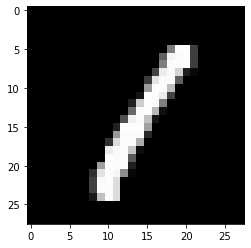

In [90]:
i = 3
print(f"Predict: {y_hat[i]}, Actual: {y[i]}")
image = np.reshape(X[i], (28, 28))
plt.imshow(image, cmap='gray')
plt.show()